In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from config import get_cfg_defaults, read_dicom_imgs

In [2]:
cfg_path = "tutorial.yaml" # Path to `.yaml` config file
# gpus = None # GPU settings

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
cfg.freeze()
print(cfg)

DATASET:
  IMG_DIR: DICOM
  LANDMARK_FILE: landmarks_64x64.csv
  MASK_FILE: Mask
  ROOT: D:/ML_data/PAH/PAH_SA_64x64
MPCA:
  CLF: 
OUTPUT:
  ROOT: ./outputs
PROC:
  SCALE: 2


Read DICOM Images

In [3]:
img_path = os.path.join(cfg.DATASET.ROOT, cfg.DATASET.IMG_DIR)
imgs = read_dicom_imgs(img_path)

mask_path = os.path.join(cfg.DATASET.ROOT, cfg.DATASET.MASK_FILE)
mask = read_dicom_imgs(mask_path)

C:\Users\sz144\anaconda3\lib\site-packages\pydicom\filereader.py:300: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(message, UserWarning)


Read Landmarks and get labels

In [4]:
df_file = os.path.join(cfg.DATASET.ROOT, cfg.DATASET.LANDMARK_FILE)
df = pd.read_csv(df_file)
landmarks = df.iloc[:, :6]
y = df['Group'].values

In [5]:
y[np.where(y != 0)] = 1

Visualising Data and Landmarks

In [6]:
def visualise_imgs(imgs, landmarks=None):

    columns = 10
    rows = int(imgs.shape[0] / columns) + 1

    fig = plt.figure(figsize=(20, 36))

    for i in range(imgs.shape[0]):
        fig.add_subplot(rows, columns, i + 1)
        plt.axis('off')
        plt.imshow(imgs[i, 0, ...])
        if landmarks is not None:
            coords = landmarks.iloc[i, :].values.reshape((-1, 2))
            n_landmark = coords.shape[0]
            for j in range(n_landmark):
                ix = coords[j, 0]
                iy = coords[j, 1]
                plt.plot(ix,iy, marker='o', markersize=5, markerfacecolor=(1, 1, 1, 0.1),markeredgewidth=1.5, markeredgecolor='r')
        plt.title(i + 1)

    # plt.savefig("imgs32_from_dicom_with_landmark.png", format='png')
    # plt.savefig("imgs32_from_dicom_with_landmark.pdf", format='pdf')
    plt.show()

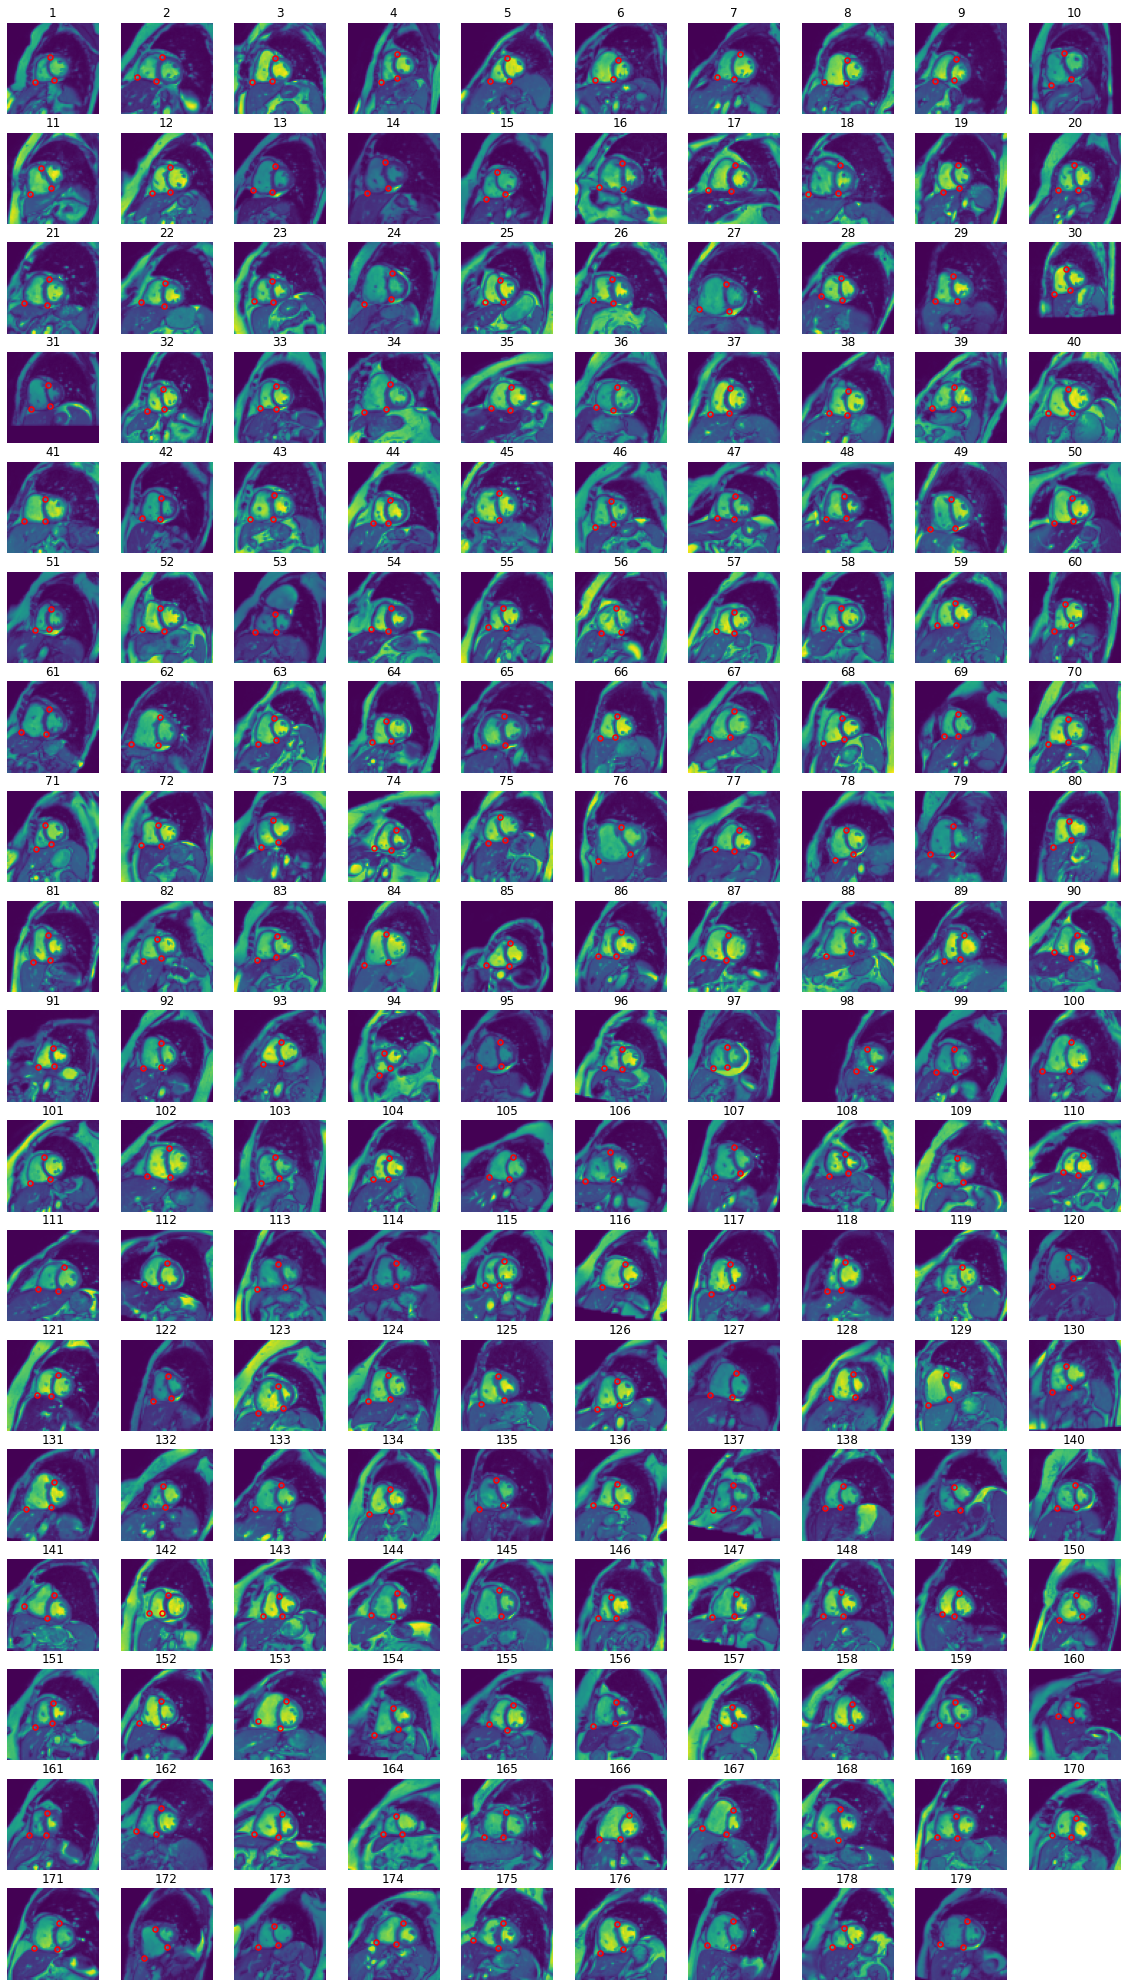

In [7]:
visualise_imgs(imgs, landmarks=landmarks)

### CMR Pre-processing

In [7]:
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), "../..")))
from kale.prepdata.image_transform import mask_img_stack, reg_img_stack, rescale_img_stack, normalize_img_stack

Image Registration

In [8]:
img_reg, max_dist = reg_img_stack(imgs, landmarks.values)

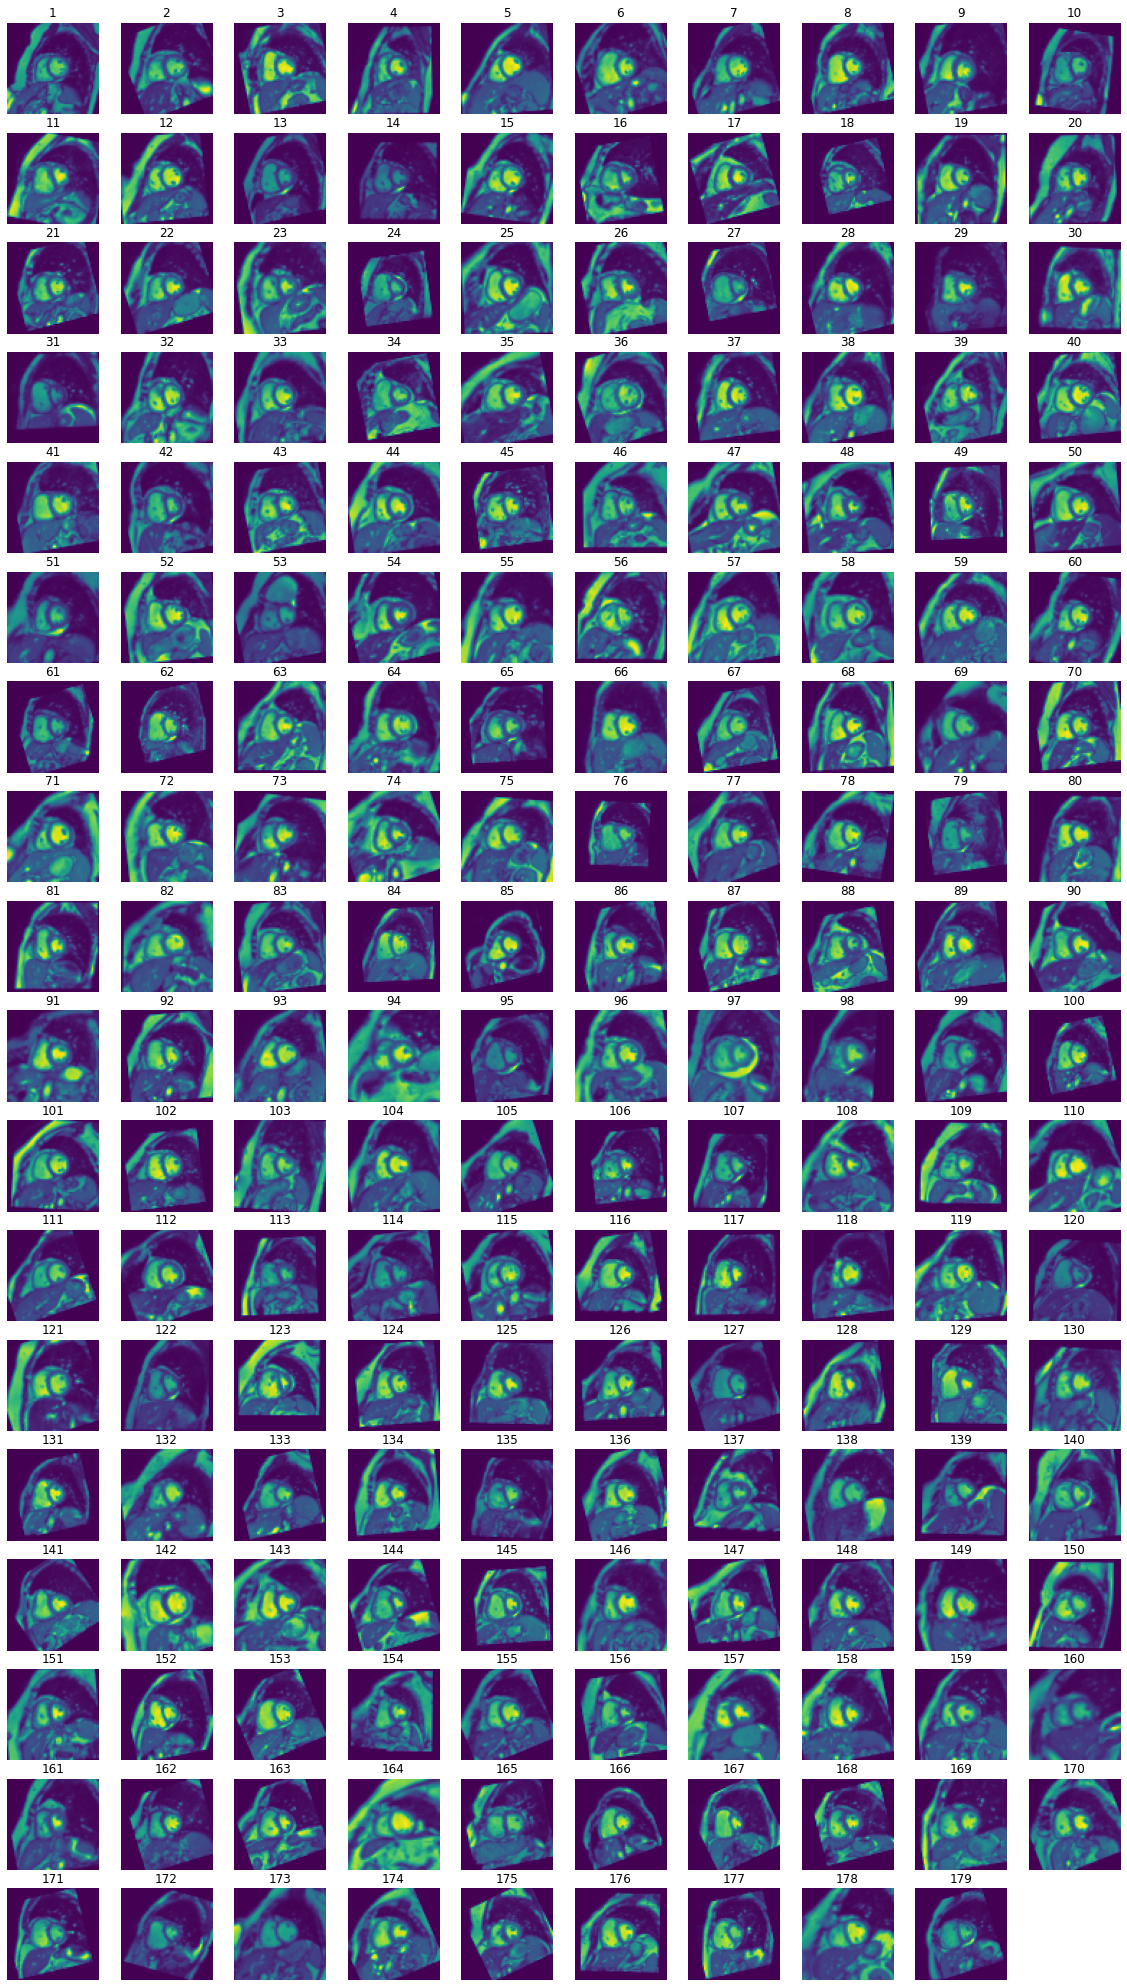

In [10]:
visualise_imgs(img_reg)

Masking

In [9]:
img_masked = mask_img_stack(img_reg, mask[0, 0, ...])

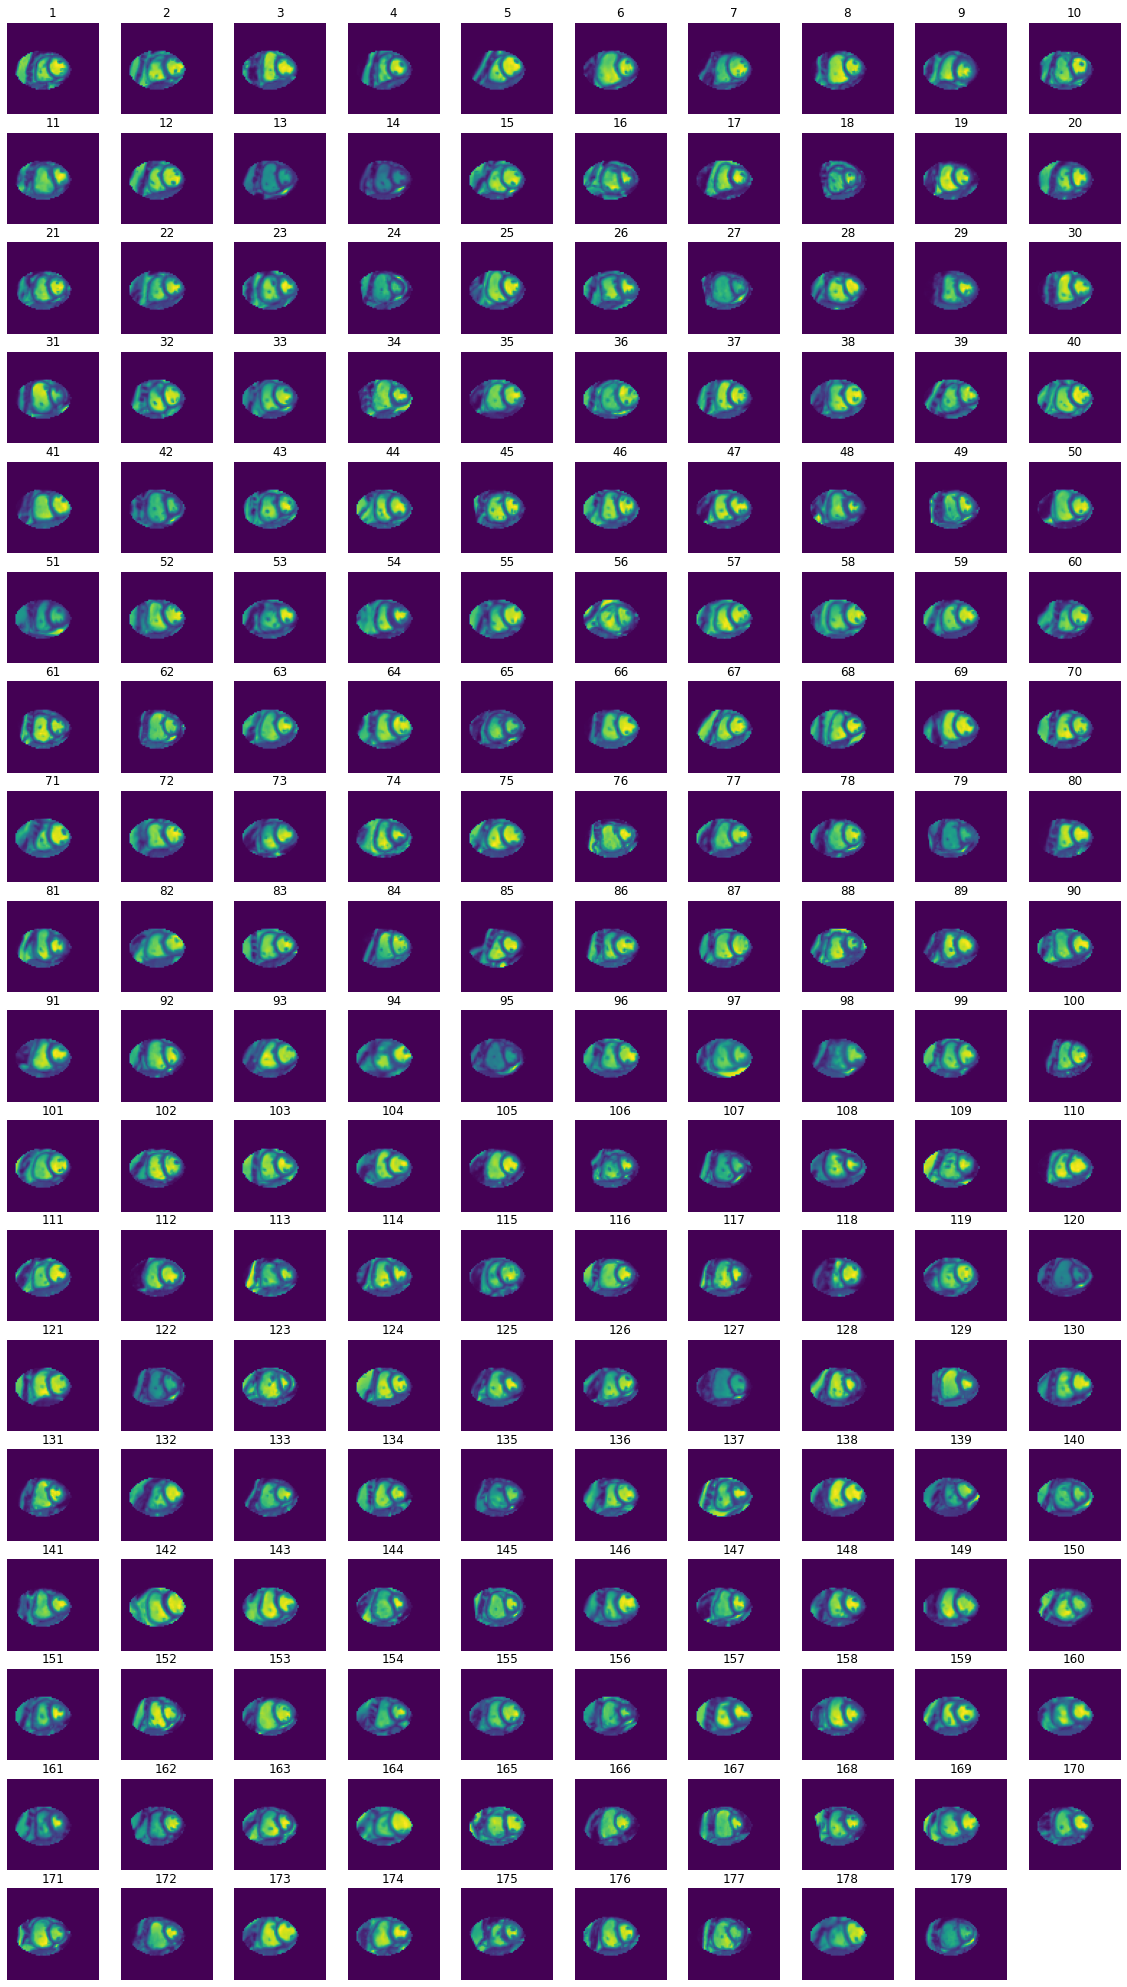

In [12]:
visualise_imgs(img_masked)

Data Rescale

In [10]:
img_rescaled = rescale_img_stack(img_masked, scale=2)

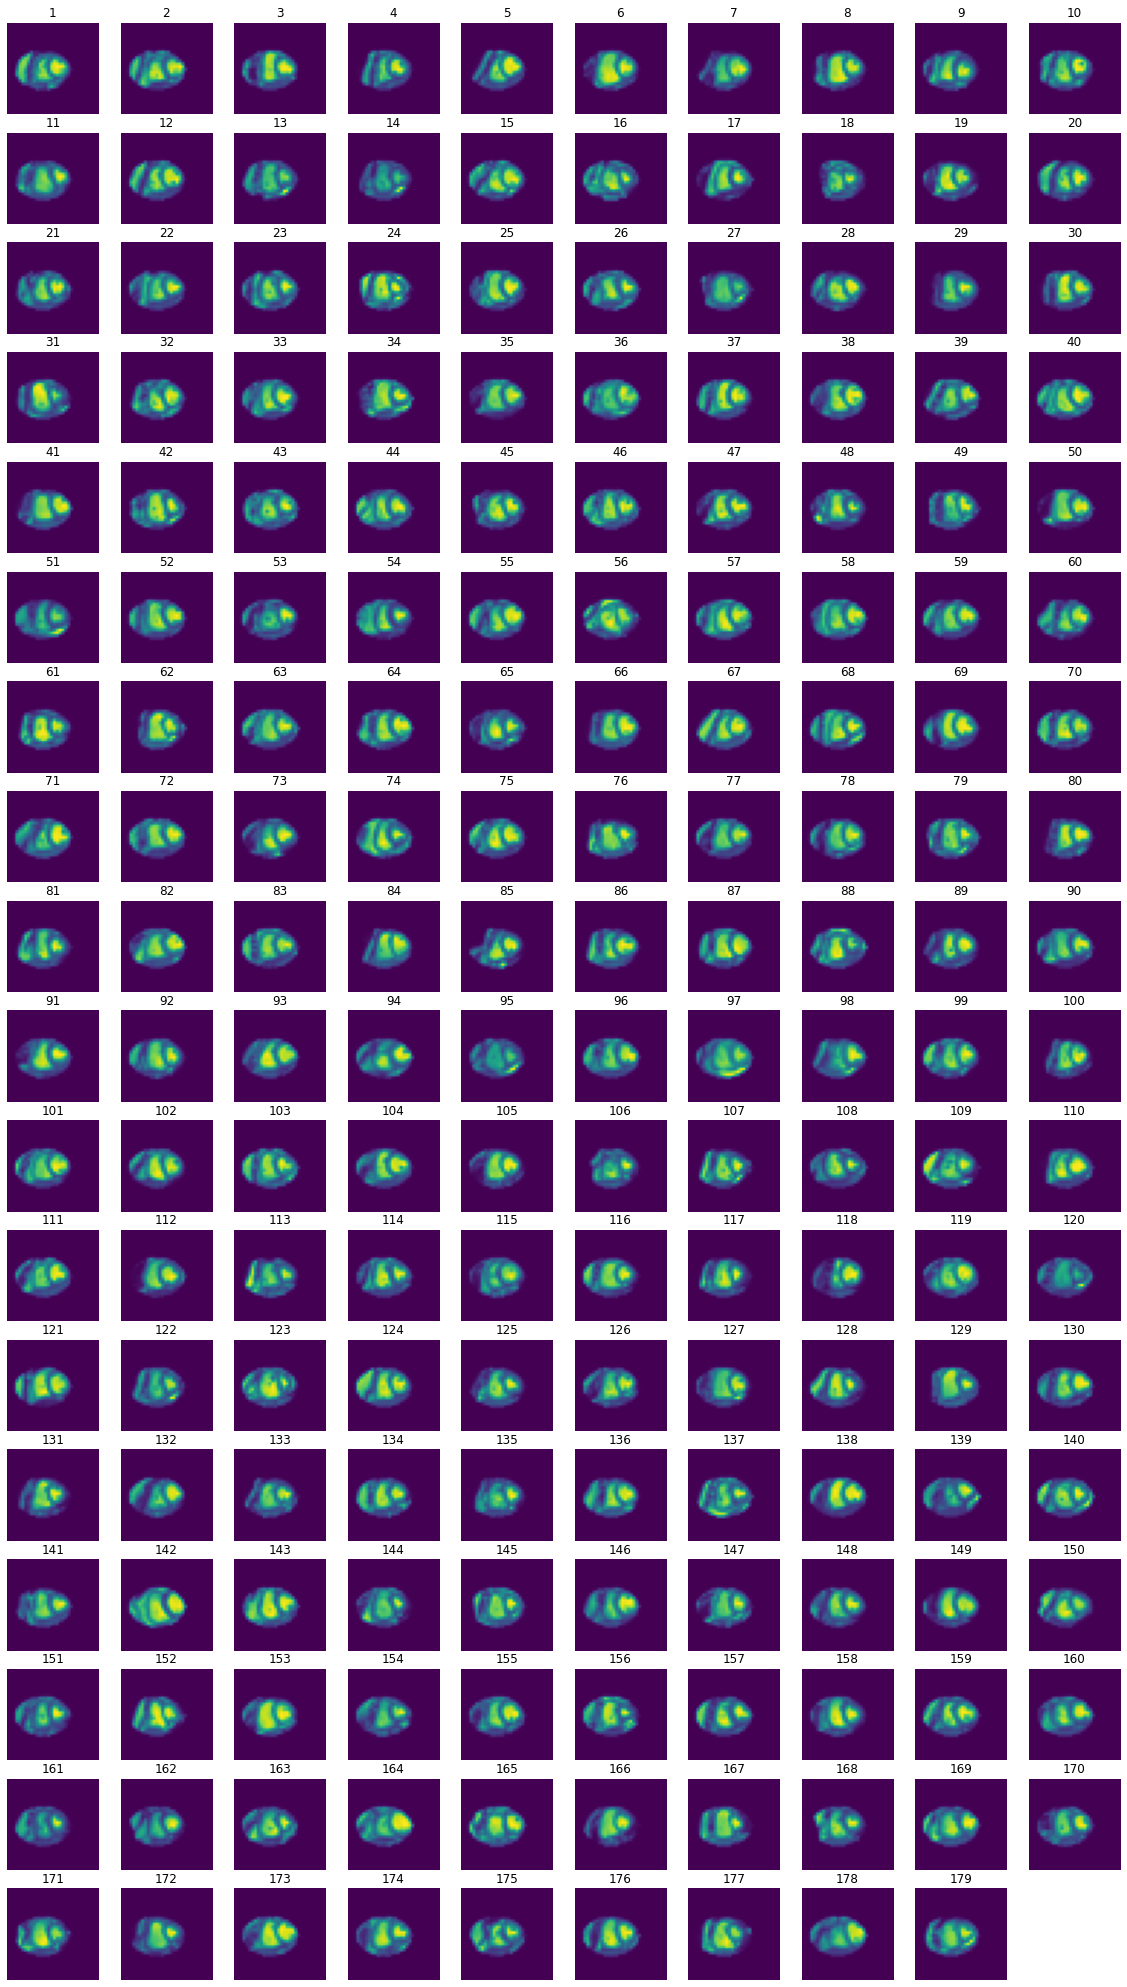

In [14]:
visualise_imgs(img_rescaled)

Normalization

In [19]:
def normalize_img_stack(images):
    """Normalization for stacked images

    Args:
        images (array-like tensor): Input data, shape (n_samples, n_phases, dim1, dim2).

    Returns:
        array-like: Normalized images, shape (n_samples, n_phases, dim1, dim2).
    """
    n_samples, n_phases = images.shape[:2]
    for i in range(n_samples):
        for j in range(n_phases):
            img = images[i, j, ...]
            images[i, j, ...] = (img - np.min(img)) / (np.max(img) - np.min(img))

    return images

In [20]:
img_norm = normalize_img_stack(img_rescaled)

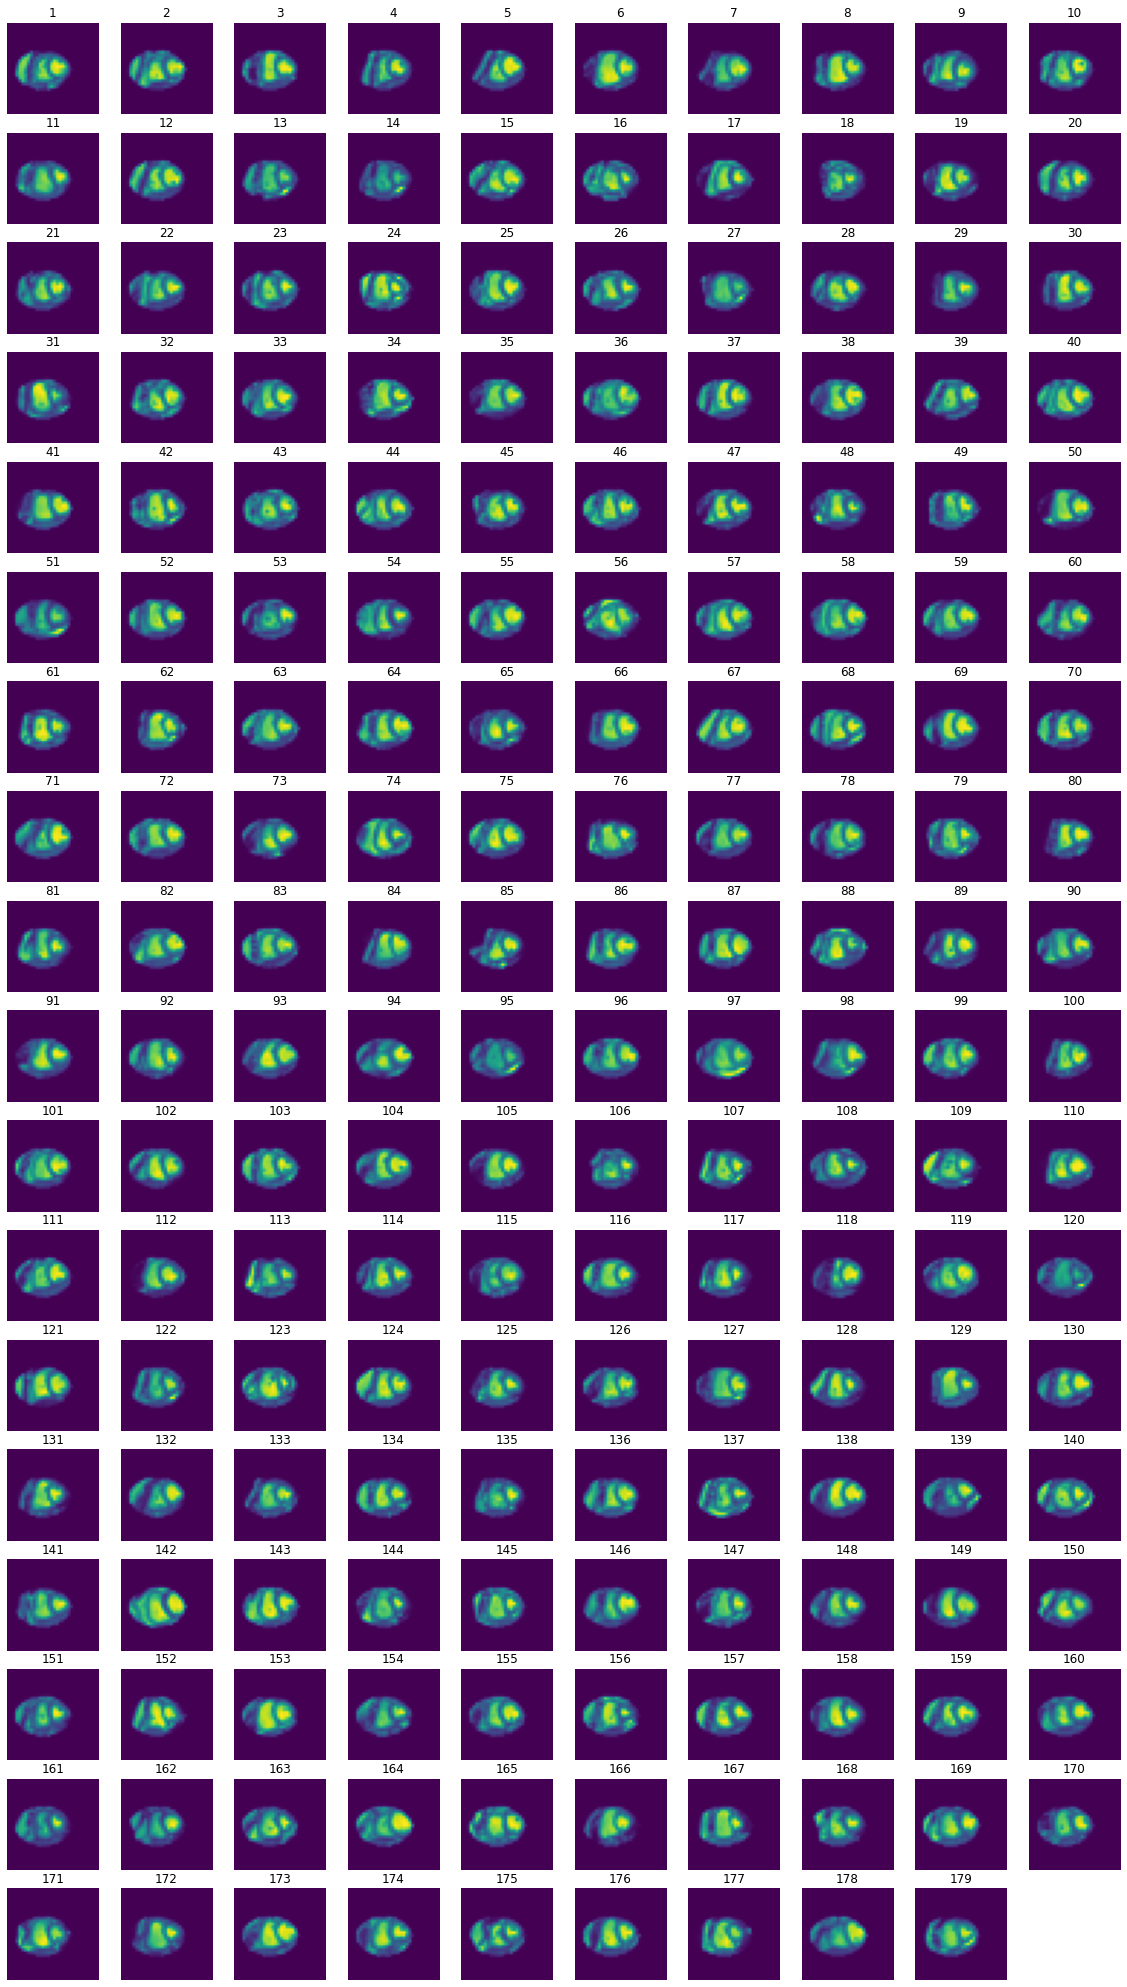

In [22]:
visualise_imgs(img_norm)

### PAH Classification

In [24]:
from kale.interpret import model_weights
from kale.pipeline.mpca_trainer import MPCATrainer

In [28]:
from sklearn.model_selection import cross_validate

x = img_norm
trainer = MPCATrainer(n_features=200)
cv_results = cross_validate(trainer, x, y, cv=10, scoring=['accuracy', 'roc_auc'], n_jobs=1)

In [29]:
cv_results

{'fit_time': array([3.47372031, 3.41966915, 3.26673484, 3.29307437, 3.19240761,
        3.31578279, 3.41618371, 3.61468959, 3.70325851, 3.47817016]),
 'score_time': array([0.04124689, 0.02048922, 0.02285409, 0.02132273, 0.02282476,
        0.02066898, 0.02064252, 0.02899528, 0.02284765, 0.03093195]),
 'test_accuracy': array([0.77777778, 0.77777778, 0.83333333, 0.72222222, 0.83333333,
        0.72222222, 0.88888889, 0.61111111, 0.77777778, 0.82352941]),
 'test_roc_auc': array([0.81818182, 0.75324675, 0.95833333, 0.91666667, 0.90277778,
        0.77777778, 0.81944444, 0.76388889, 0.86111111, 0.71212121])}

In [32]:
print("Accuracy: ", np.mean(cv_results['test_accuracy']))
print("AUC: ", np.mean(cv_results['test_roc_auc']))

Accuracy:  0.7767973856209149
AUC:  0.8283549783549784


### Model Interpretation

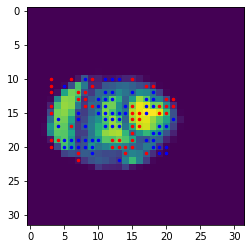

In [33]:
from kale.interpret import model_weights

trainer.fit(x, y)

weights = trainer.mpca.inverse_transform(trainer.clf.coef_) - trainer.mpca.mean_
top_weights = model_weights.select_top_weight(weights, select_ratio=0.1)
fig = model_weights.plot_weights(top_weights[0][0], background_img=x[0][0])